In [1]:
import pandas as pd
import numpy as np

# import holidays for colombia
import holidays
from datetime import date



In [2]:
# check if a date is a holiday
def is_holiday(date):
    return date in holidays.CO()

def is_weekend(date):
    return date.weekday() >= 5

today = date.today().strftime("%Y-%m-%d")
print("Today's date:", today , "is holiday?", is_holiday(today))

Today's date: 2023-12-10 is holiday? False


[(1, 20), (15, 12), (23, 5), (86, 3)]
[(92, 46), (62, 83), (67, 60), (28, 18), (23, 5), (45, 93), (19, 19), (64, 17), (60, 20), (77, 26), (68, 40), (36, 53), (87, 37), (26, 43), (31, 25), (24, 82), (38, 53), (71, 61), (8, 76), (69, 62), (75, 55), (64, 56), (79, 82), (42, 99), (3, 67), (86, 3), (15, 12), (75, 69), (11, 44), (86, 52), (47, 17), (94, 75), (95, 54), (1, 20), (95, 29), (32, 80), (71, 8), (6, 38), (51, 36), (67, 72)]


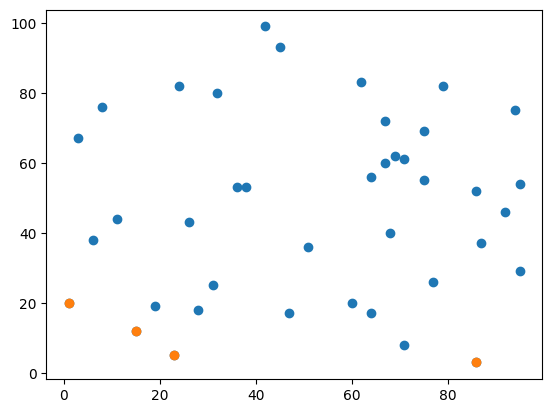

In [3]:
#random set of points
import numpy as np
import matplotlib.pyplot as plt

pairs=[(np.random.randint(0,100),np.random.randint(0,100)) for i in range(40)]


def get_non_dominated_pairs(pairs):
    # sort pairs by first element in ascending order
    
    pairs=sorted(pairs,key=lambda x: x[0])
    
    non_dominated_pairs=[pairs[0]]
    y_min=pairs[0][1]
    
    for i in range(len(pairs)):
        non_dominated=True
        for j in range(i+1,len(pairs)):
            if pairs[j][1]<y_min:
                y_min=pairs[j][1]
                non_dominated_pairs.append(pairs[j])
            else:
                non_dominated=False


            
    return non_dominated_pairs

non_dominated_pairs=get_non_dominated_pairs(pairs)
non_dominated_pairs
print(non_dominated_pairs)
print(pairs)

plt.scatter([i[0] for i in pairs],[i[1] for i in pairs])
plt.scatter([i[0] for i in non_dominated_pairs],[i[1] for i in non_dominated_pairs])

In [4]:
# construct a dataframe with the name of the instance, the objectives and the non-dominated pairs
list_of_instances=[]
for i in range(3,171):
    try:

        prefix='/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/'
        instance_name=f'tabulated_shifts_{i}.csv'

        df=pd.read_csv(prefix+instance_name)

        # skip columns objective_1 and objective_2
        # old_data.loc[:, ~old_data.columns.str.contains('^Unnamed')]
        # melt all columns
        #get columns names
        cols=list(df.columns)

        #remove first column
        cols.pop(0)
        #melt
        df_melt=pd.melt(df,id_vars=['objective_1','objective_2'],value_vars=cols)
        df_melt.drop(columns=['variable'],inplace=True)
        df_melt.drop(columns=['value'],inplace=True)
        
        df_melt['instance_name']=instance_name
        df_melt.drop_duplicates(inplace=True)
        # re-escale objective_1 in the range [0,1] with min-max
        df_melt['objective_1_scaled'] = (df_melt['objective_1'] - df_melt['objective_1'].min()) / (df_melt['objective_1'].max() - df_melt['objective_1'].min())
        # re-escale objective_2 in the range [0,1] with min-max
        df_melt['objective_2_scaled'] = (df_melt['objective_2'] - df_melt['objective_2'].min()) / (df_melt['objective_2'].max() - df_melt['objective_2'].min())
        
        ideal_point=df_melt[['objective_1_scaled','objective_2_scaled']].min().values


        df_melt['distance_to_ideal_point']=df_melt.apply(lambda x: np.sqrt((x['objective_1_scaled']-ideal_point[0])**2+(x['objective_2_scaled']-ideal_point[1])**2),axis=1)

        df_melt['objective_tuples']=df_melt.apply(lambda x: (x['objective_1'],x['objective_2']),axis=1)
        dict_non_dominated=df_melt.groupby(df_melt['instance_name']).agg({'objective_tuples':get_non_dominated_pairs}).reset_index().set_index('instance_name').to_dict()['objective_tuples']

        df_melt['non_dominated']=df_melt.apply(lambda x: 1 if (x['objective_1'],x['objective_2']) in dict_non_dominated[x['instance_name']] else 0,axis=1)
        df_melt=df_melt[df_melt['non_dominated']==1].copy()
        df_melt['non_dominated_size']=len(dict_non_dominated[instance_name])

        df_ins=pd.read_json(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/nurses_{i}.json')
        df_ins['dates_off']=df_ins['dates_off'].apply(lambda x: [x[i] for i in range(len(x))])
        df_ins['len_dates_off']=df_ins['dates_off'].apply(lambda x: len(x))
        df_ins['len_vacations']=df_ins['vacations'].apply(lambda x: len(x))
        
        df_ins['vacations_asked']=df_ins['vacations'].apply(lambda x: 1 if len(x)>0 else 0)
        df_ins['total_vacations']=df_ins['vacations'].apply(lambda x: len(x))

        df_res=df_ins.groupby('nurse_name').agg({'dates_off':'sum'
                                                 ,'len_dates_off':'sum'
                                                 ,'len_vacations':'sum'
                                                 ,'vacations_asked':'sum'
                                                 ,'total_vacations':'sum'}).reset_index()
        
        df_melt["total_dates_off"]=df_res['len_dates_off'].sum()
        df_melt["total_vacations"]=df_res['total_vacations'].sum()
        df_melt["total_vacations_asked"]=df_res['vacations_asked'].sum()
        df_melt["total_nurses"]=len(df_res)

        df_shifts=pd.read_json(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/shifts_{i}.json')
        #print(df_shifts.head())
        df_shifts['shift_date']=pd.to_datetime(df_shifts['shift_date'])

        shift_dates=df_shifts['shift_date'].unique()
        total_holidays,total_days_weekend=sum([1 for i in shift_dates if is_holiday(i)]),sum([1 for i in shift_dates if is_weekend(i)])
        df_melt['total_holidays']=total_holidays
        df_melt['total_days_weekend']=total_days_weekend
        list_of_instances.append(df_melt)
    except:
        pass


df_final=pd.concat(list_of_instances)

df_final.to_excel('metrics_instances.xlsx')



In [26]:
dict_len_non_dominated={i:len(dict_non_dominated[i]) for i in dict_non_dominated.keys()}


In [24]:
df_final.dropna(subset=['objective_1_scaled','objective_2_scaled'],inplace=True)
df_final.sort_values(by=['instance_name','objective_1_scaled','objective_2_scaled'],ascending=[True,True,True],inplace=True)
df_final.head(50)

,objective_1,objective_2,instance_name,objective_1_scaled,objective_2_scaled,distance_to_ideal_point,objective_tuples,non_dominated,non_dominated_size,total_dates_off,total_vacations,total_vacations_asked,total_nurses,total_holidays,total_days_weekend
0,2.0,12.6250,tabulated_shifts_102.csv,0.000000,1.000000,1.000000,"(2.0, 12.625)",1,10,46,0,0,10,2,9
10,4.0,11.5000,tabulated_shifts_102.csv,0.200000,0.763158,0.788930,"(4.0, 11.5)",1,10,46,0,0,10,2,9
20,5.0,10.6250,tabulated_shifts_102.csv,0.300000,0.578947,0.652058,"(5.0, 10.625000000000009)",1,10,46,0,0,10,2,9
30,6.0,10.5000,tabulated_shifts_102.csv,0.400000,0.552632,0.682204,"(6.0, 10.5)",1,10,46,0,0,10,2,9
40,7.0,9.6250,tabulated_shifts_102.csv,0.500000,0.368421,0.621075,"(7.0, 9.625000000000004)",1,10,46,0,0,10,2,9
50,8.0,9.5000,tabulated_shifts_102.csv,0.600000,0.342105,0.690678,"(8.0, 9.5)",1,10,46,0,0,10,2,9
60,9.0,8.6250,tabulated_shifts_102.csv,0.700000,0.157895,0.717587,"(9.0, 8.625000000000004)",1,10,46,0,0,10,2,9
70,10.0,8.5000,tabulated_shifts_102.csv,0.800000,0.131579,0.810748,"(10.0, 8.5)",1,10,46,0,0,10,2,9
80,11.0,8.0625,tabulated_shifts_102.csv,0.900000,0.039474,0.900865,"(11.0, 8.0625)",1,10,46,0,0,10,2,9
90,12.0,7.8750,tabulated_shifts_102.csv,1.000000,0.000000,1.000000,"(12.0, 7.875)",1,10,46,0,0,10,2,9


In [21]:
len(df_final.instance_name.unique())

95

In [12]:
list_dfs=[]
for i in range(2,171):
    try:
        df=pd.read_csv(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/tabulated_shifts_{i}.csv')

        # skip columns objective_1 and objective_2
        # old_data.loc[:, ~old_data.columns.str.contains('^Unnamed')]
        # melt all columns
        #get columns names
        cols=list(df.columns)


        #remove first column
        cols.pop(0)
        #melt
        df_melt=pd.melt(df,id_vars=['Nurse','objective_1','objective_2'],value_vars=cols)
        
        # re-escale objective_1 in the range [0,1] with min-max
        df_melt['objective_1'] = (df_melt['objective_1'] - df_melt['objective_1'].min()) / (df_melt['objective_1'].max() - df_melt['objective_1'].min())
        # re-escale objective_2 in the range [0,1] with min-max
        df_melt['objective_2'] = (df_melt['objective_2'] - df_melt['objective_2'].min()) / (df_melt['objective_2'].max() - df_melt['objective_2'].min())
        
        ideal_point=df_melt[['objective_1','objective_2']].min().values


        df_melt['distance_to_ideal_point']=df_melt.apply(lambda x: np.sqrt((x['objective_1']-ideal_point[0])**2+(x['objective_2']-ideal_point[1])**2),axis=1)

        df_melt["horario"]=df_melt["variable"].str.split("-", n = 3, expand = True)[3]
        df_melt['fecha']=df_melt['variable'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1]+'-'+x.split('-')[2])
        df_melt['fecha']=pd.to_datetime(df_melt['fecha'])
        df_melt["works"]=df_melt["value"].apply(lambda x: 1 if x!='-' else 0)
        df_melt["works_morning_shift"]=df_melt.apply(lambda x: 1 if (x['horario']=='mañana'  and x['value']!='-') else 0, axis=1)
        df_melt["works_afternoon_shift"]=df_melt.apply(lambda x: 1 if (x['horario']=='tarde'  and x['value']!='-') else 0, axis=1)
        df_melt['works']=df_melt['works'].astype(int)
        df_melt["works_M"]=df_melt.apply(lambda x: 1 if (x['value']=='M') else 0, axis=1)
        df_melt["works_COM"]=df_melt.apply(lambda x: 1 if (x['value']=='COM') else 0, axis=1)
        df_melt["works_DISP"]=df_melt.apply(lambda x: 1 if (x['value']=='DISP') else 0, axis=1)

        df_melt["works_T1"]=df_melt.apply(lambda x: 1 if (x['value']=='T1') else 0, axis=1)
        df_melt["works_T2"]=df_melt.apply(lambda x: 1 if (x['value']=='T2') else 0, axis=1)
        df_melt["works_CHX"]=df_melt.apply(lambda x: 1 if (x['value']=='CHX') else 0, axis=1)

        df_melt['is_holiday']=df_melt['fecha'].apply(lambda x: is_holiday(x))
        df_melt['is_weekend']=df_melt['fecha'].apply(lambda x: is_weekend(x))

        df_res=df_melt.groupby(['Nurse','objective_1','objective_2']).agg({'works':'sum'
                                                                           ,'works_morning_shift':'sum'
                                                                           ,'works_afternoon_shift':'sum'
                                                                           ,'works_M':'sum'
                                                                           ,'works_COM':'sum'
                                                                           ,'works_DISP':'sum'
                                                                           ,'works_T1':'sum'
                                                                           ,'works_T2':'sum'
                                                                           ,'works_CHX':'sum'
                                                                           , 'is_holiday':'sum'
                                                                            , 'is_weekend':'sum'
                                                                            ,'distance_to_ideal_point':'min'
                                                                           }).reset_index()
        
        df_ins=pd.read_json(f'instances/nurses_{i}.json')
        df_ins['dates_off']=df_ins['dates_off'].apply(lambda x: [x[i] for i in range(len(x))])
        df_ins['len_dates_off']=df_ins['dates_off'].apply(lambda x: len(x))
        df_ins['len_vacations']=df_ins['vacations'].apply(lambda x: len(x))
        
        df_ins['vacations_asked']=df_ins['vacations'].apply(lambda x: 1 if len(x)>0 else 0)
        df_ins['total_vacations']=df_ins['vacations'].apply(lambda x: len(x))

        df_ins['instance']=i
        list_dfs.append(df_ins.merge(df_res,how='left',left_on='nurse_name',right_on='Nurse'))
    except:
        print(i)
        pass

df_all=pd.concat(list_dfs)


2
4
11
17
18
21
22
23
26
27
29
35
38
44
45
46
49
50
57
60
62
63
65
67
69
71
72
76
81
82
91
93
100
101
104
108
119
122
128
129
133
134
136
137
141
142
144
146
151
153
155
165


In [13]:
df_all.to_pickle('instances/all_instances_results.pkl')
df_all

,nurse_id,nurse_name,shift_preference,morning_availability_labor_day,morning_availability_weekend,afternoon_availability_labor_day,afternoon_availability_weekend,dates_off,accumulated_hours,vacations,...,works_afternoon_shift,works_M,works_COM,works_DISP,works_T1,works_T2,works_CHX,is_holiday,is_weekend,distance_to_ideal_point
0,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,7.0,8.0,4.0,2.0,5.0,2.0,0.0,4.0,18.0,1.000000
1,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,2.0,9.0,9.0,1.0,1.0,1.0,0.0,4.0,18.0,0.665107
2,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,6.0,8.0,5.0,3.0,3.0,2.0,1.0,4.0,18.0,0.766440
3,4,person_1,morning,0,1,1,1,"[5, 13, 19, 26, 27]",-25.5,[],...,5.0,5.0,11.0,2.0,3.0,2.0,0.0,4.0,18.0,1.000000
4,20,person_2,morning,0,1,1,1,[],-19.0,[],...,7.0,9.0,7.0,0.0,5.0,0.0,2.0,4.0,18.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,2.0,13.0,7.0,0.0,0.0,1.0,1.0,4.0,18.0,0.663331
192,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,2.0,9.0,10.0,2.0,0.0,1.0,1.0,4.0,18.0,0.717800
193,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,5.0,18.0,21.0,2.0,1.0,1.0,3.0,8.0,36.0,0.766613
194,25,person_14,morning,1,1,0,1,"[2, 8, 15, 16, 29, 30]",-36.0,[],...,9.0,21.0,14.0,2.0,0.0,6.0,3.0,8.0,36.0,0.882026


In [19]:
len(df_all['instance'].unique())

117

In [15]:
df_all['objective_tuples']=df_all.apply(lambda x: (x['objective_1'],x['objective_2']),axis=1)
dict_non_dominated=df_all.groupby(df_all['instance']).agg({'objective_tuples':get_non_dominated_pairs}).reset_index().set_index('instance').to_dict()['objective_tuples']
df_all['non_dominated']=df_all.apply(lambda x: 1 if (x['objective_1'],x['objective_2']) in dict_non_dominated[x['instance']] else 0,axis=1)



In [17]:
dict_non_dominated[98]

[(nan, nan)]

In [16]:
df_all['proportion_of_shifts_in_preference']=df_all.apply(lambda x: x['works_morning_shift']/x['works'] if x['shift_preference']=='morning' else x['works_afternoon_shift']/x['works'],axis=1)

pd.set_option('display.max_columns', None)
df_all['vacations_askes']=df_all['vacations'].apply(lambda x: 1 if len(x)>0 else 0)
df_all['total_vacations']=df_all['vacations'].apply(lambda x: len(x))
df_all.head(20)

,nurse_id,nurse_name,shift_preference,morning_availability_labor_day,morning_availability_weekend,afternoon_availability_labor_day,afternoon_availability_weekend,dates_off,accumulated_hours,vacations,len_dates_off,len_vacations,vacations_asked,total_vacations,instance,Nurse,objective_1,objective_2,works,works_morning_shift,works_afternoon_shift,works_M,works_COM,works_DISP,works_T1,works_T2,works_CHX,is_holiday,is_weekend,distance_to_ideal_point,objective_tuples,non_dominated,proportion_of_shifts_in_preference,vacations_askes
0,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.000000,1.000000,38.0,26.0,12.0,12.0,12.0,2.0,4.0,2.0,6.0,0.0,32.0,1.000000,"(0.0, 1.0)",1,0.684211,0
1,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.166667,0.636364,40.0,32.0,8.0,16.0,16.0,0.0,2.0,4.0,2.0,0.0,32.0,0.657827,"(0.16666666666666666, 0.6363636363636364)",1,0.800000,0
2,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.250000,0.613636,42.0,42.0,0.0,16.0,24.0,2.0,0.0,0.0,0.0,0.0,32.0,0.662608,"(0.25, 0.6136363636363636)",1,1.000000,0
3,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.333333,0.545455,42.0,36.0,6.0,20.0,12.0,4.0,0.0,4.0,2.0,0.0,32.0,0.639243,"(0.3333333333333333, 0.5454545454545454)",1,0.857143,0
4,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.416667,0.500000,42.0,32.0,10.0,14.0,14.0,4.0,0.0,4.0,6.0,0.0,32.0,0.650854,"(0.4166666666666667, 0.5)",1,0.761905,0
5,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.500000,0.340909,42.0,34.0,8.0,20.0,10.0,4.0,2.0,4.0,2.0,0.0,32.0,0.605160,"(0.5, 0.3409090909090909)",1,0.809524,0
6,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.583333,0.272727,42.0,32.0,10.0,18.0,10.0,4.0,2.0,0.0,8.0,0.0,32.0,0.643939,"(0.5833333333333334, 0.2727272727272727)",1,0.761905,0
7,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.666667,0.250000,44.0,36.0,8.0,14.0,18.0,4.0,2.0,0.0,6.0,0.0,32.0,0.712000,"(0.6666666666666666, 0.25)",1,0.818182,0
8,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.750000,0.181818,44.0,36.0,8.0,16.0,16.0,4.0,4.0,0.0,4.0,0.0,32.0,0.771724,"(0.75, 0.18181818181818182)",1,0.818182,0
9,47,person_1,morning,0,1,0,1,"[1, 7, 15, 21, 28, 29]",0.0,[],6,0,0,0,2,person_1,0.833333,0.136364,44.0,34.0,10.0,14.0,16.0,4.0,6.0,2.0,2.0,0.0,32.0,0.844417,"(0.8333333333333334, 0.13636363636363635)",1,0.772727,0


In [17]:
df_all.groupby(['instance','objective_1','objective_2']).agg({'works':['mean','std','max','min'],'proportion_of_shifts_in_preference':['mean','std']}).reset_index()

instance objective_1 objective_2      works                        \
                                           mean       std   max   min   
0          2    0.000000    1.000000  42.400000  2.633122  46.0  38.0   
1          2    0.166667    0.636364  44.400000  2.633122  48.0  40.0   
2          2    0.250000    0.613636  44.800000  2.149935  48.0  42.0   
3          2    0.333333    0.545455  45.200000  2.149935  48.0  42.0   
4          2    0.416667    0.500000  46.000000  2.309401  48.0  42.0   
5          2    0.500000    0.340909  46.200000  2.394438  48.0  42.0   
6          2    0.583333    0.272727  46.600000  2.503331  50.0  42.0   
7          2    0.666667    0.250000  46.600000  2.319004  50.0  44.0   
8          2    0.750000    0.181818  46.800000  2.529822  50.0  44.0   
9          2    0.833333    0.136364  47.000000  2.708013  50.0  44.0   
10         2    0.916667    0.000000  47.400000  2.988868  50.0  44.0   
11         2    1.000000    0.000000  47.600000  2.796824  50.0  44.0   
12         3    0.000000    1.000000  20.125000  2.531939  23.0  17.0   
13         3    0.500000    0.438596  20.875000  1.552648  24.0  19.0   
14         3    0.750000    0.157895  22.000000  1.603567  25.0  20.0   
15         3    1.000000    0.000000  22.625000  1.922610  26.0  20.0   
16         5    0.000000    1.000000  18.500000  1.927248  22.0  16.0   
17         5    0.285714    0.581818  19.125000  1.642081  22.0  17.0   
18         5    0.428571    0.418182  19.250000  1.982062  22.0  16.0   
19         5    0.571429    0.290909  19.500000  2.138090  22.0  16.0   
20         5    0.714286    0.127273  20.125000  2.100170  22.0  17.0   
21         5    0.857143    0.127273  20.750000  1.388730  22.0  18.0   
22         5    1.000000    0.000000  20.500000  2.138090  23.0  17.0   
23         6    0.000000    1.000000  19.250000  1.752549  23.0  17.0   
24         6    0.166667    0.850000  19.000000  1.927248  21.0  16.0   
25         6    0.250000    0.733333  20.000000  1.309307  21.0  17.0   
26         6    0.333333    0.700000  19.375000  1.597990  21.0  17.0   
27         6    0.416667    0.583333  19.500000  1.603567  21.0  17.0   
28         6    0.500000    0.466667  20.000000  1.511858  22.0  18.0   
29         6    0.583333    0.433333  20.125000  1.642081  22.0  18.0   
30         6    0.666667    0.316667  20.250000  1.669046  22.0  18.0   
31         6    0.750000    0.200000  20.500000  2.000000  23.0  18.0   
32         6    0.833333    0.166667  20.375000  1.922610  23.0  18.0   
33         6    0.916667    0.050000  21.125000  1.959410  23.0  18.0   
34         6    1.000000    0.000000  20.875000  1.959410  23.0  18.0   
35         7    0.000000    1.000000  21.250000  1.581139  23.0  18.0   
36         7    0.181818    0.711864  21.750000  1.488048  24.0  19.0   
37         7    0.272727    0.457627  22.125000  1.552648  24.0  19.0   
38         7    0.363636    0.440678  21.875000  2.531939  25.0  18.0   
39         7    0.454545    0.322034  21.875000  2.799872  25.0  16.0   
40         7    0.545455    0.322034  22.000000  2.390457  25.0  18.0   
41         7    0.636364    0.186441  22.625000  1.846812  25.0  20.0   
42         7    0.727273    0.169492  22.750000  2.314550  26.0  19.0   
43         7    0.818182    0.050847  46.125000  4.223658  52.0  40.0   
44         7    1.000000    0.000000  23.125000  2.416461  26.0  20.0   
45         8    0.000000    1.000000  20.625000  1.846812  23.0  18.0   
46         8    0.166667    0.724138  20.875000  1.457738  23.0  19.0   
47         8    0.250000    0.517241  21.375000  1.685018  23.0  18.0   
48         8    0.333333    0.448276  21.500000  1.603567  24.0  19.0   
49         8    0.416667    0.344828  21.625000  1.846812  24.0  18.0   
50         8    0.500000    0.275862  22.000000  1.309307  24.0  20.0   
51         8    0.583333    0.241379  22.000000  1.603567  24.0  19.0   
52         8    0.666667    0.189655  22.125000  1.807722  25.

In [12]:

instance=120
df_shifts=pd.read_json(f'/Users/fabiancastano/PycharmProjects/HHCRSP/proyecto_HHCRSP/instances/shifts_{instance}.json')
df_shifts['instance']=instance
df_shifts[['instance','weekday','shift','shift_type','holiday','demand']].drop_duplicates().reset_index(drop=True)

,instance,weekday,shift,shift_type,holiday,demand
0,120,6,M,morning,True,1
1,120,6,COM,morning,True,0
2,120,6,DISP,morning,True,1
3,120,6,T1,afternoon,True,1
4,120,6,T2,afternoon,True,0
5,120,6,CHX,afternoon,True,0
6,120,0,M,morning,False,2
7,120,0,COM,morning,False,1
8,120,0,DISP,morning,False,0
9,120,0,T1,afternoon,False,1


/var/folders/th/h1p304h17jq5pt71wrjdmbgr0000gn/T/ipykernel_33520/996395537.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="objective_1", y="proportion_of_shifts_in_preference",  data=df_all[df_all['non_dominated']==1], palette="Set3",ax=ax)


<Axes: xlabel='objective_1', ylabel='proportion_of_shifts_in_preference'>

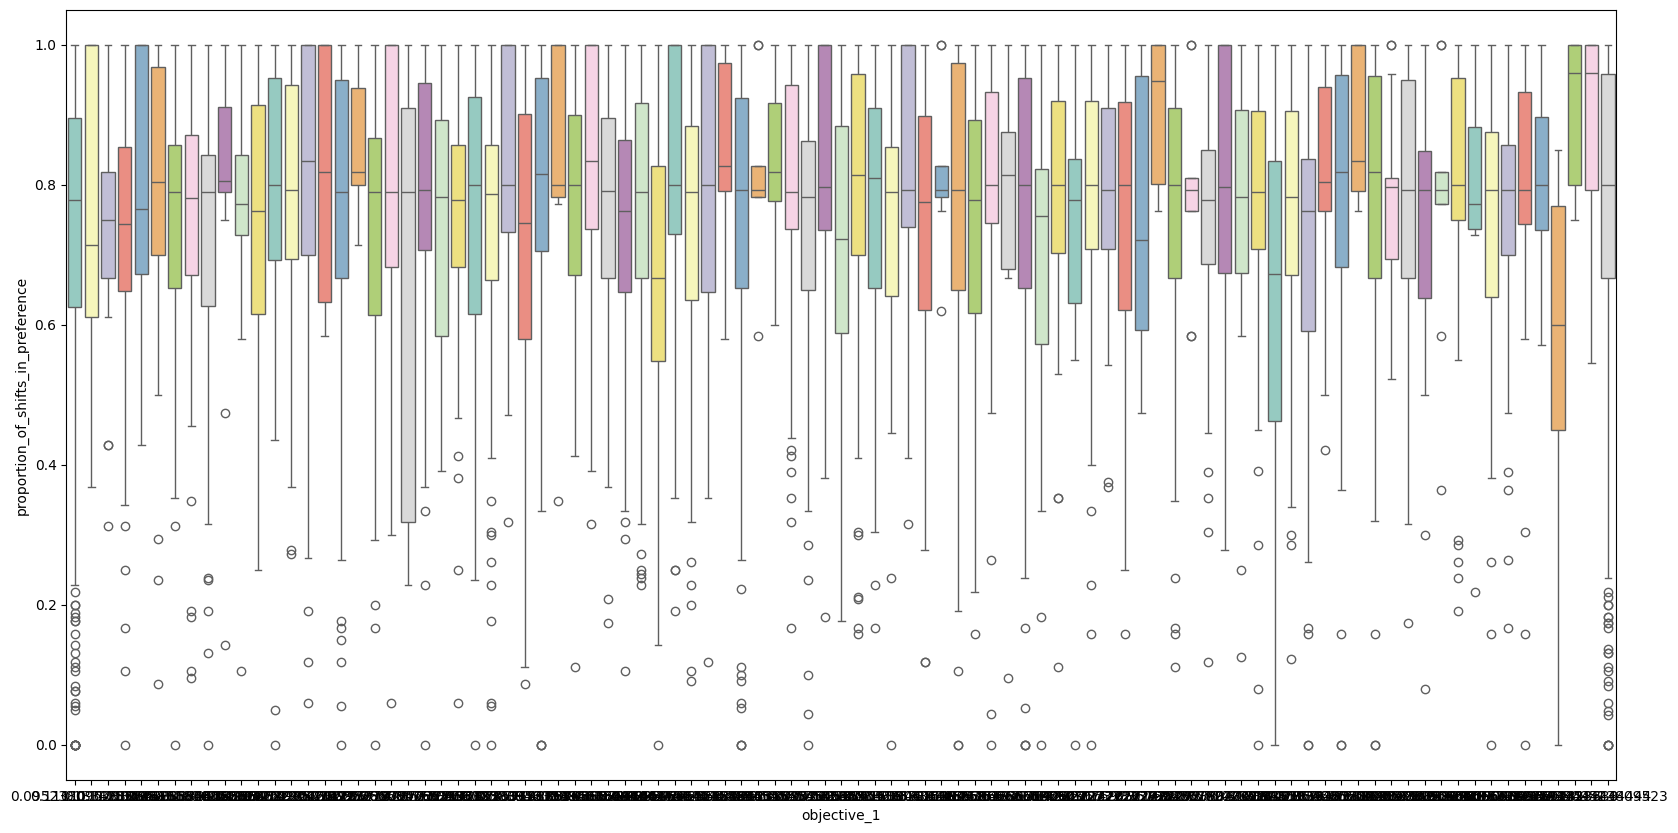

In [19]:
pd.set_option('display.max_rows', None)
df_all[df_all['non_dominated']==1].head(100)

# builds a boxplot for proportion_of_shifts_in_preference using objective_1 
import seaborn as sns
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(x="objective_1", y="proportion_of_shifts_in_preference",  data=df_all[df_all['non_dominated']==1], palette="Set3",ax=ax)


<Axes: xlabel='objective_2', ylabel='proportion_of_shifts_in_preference'>

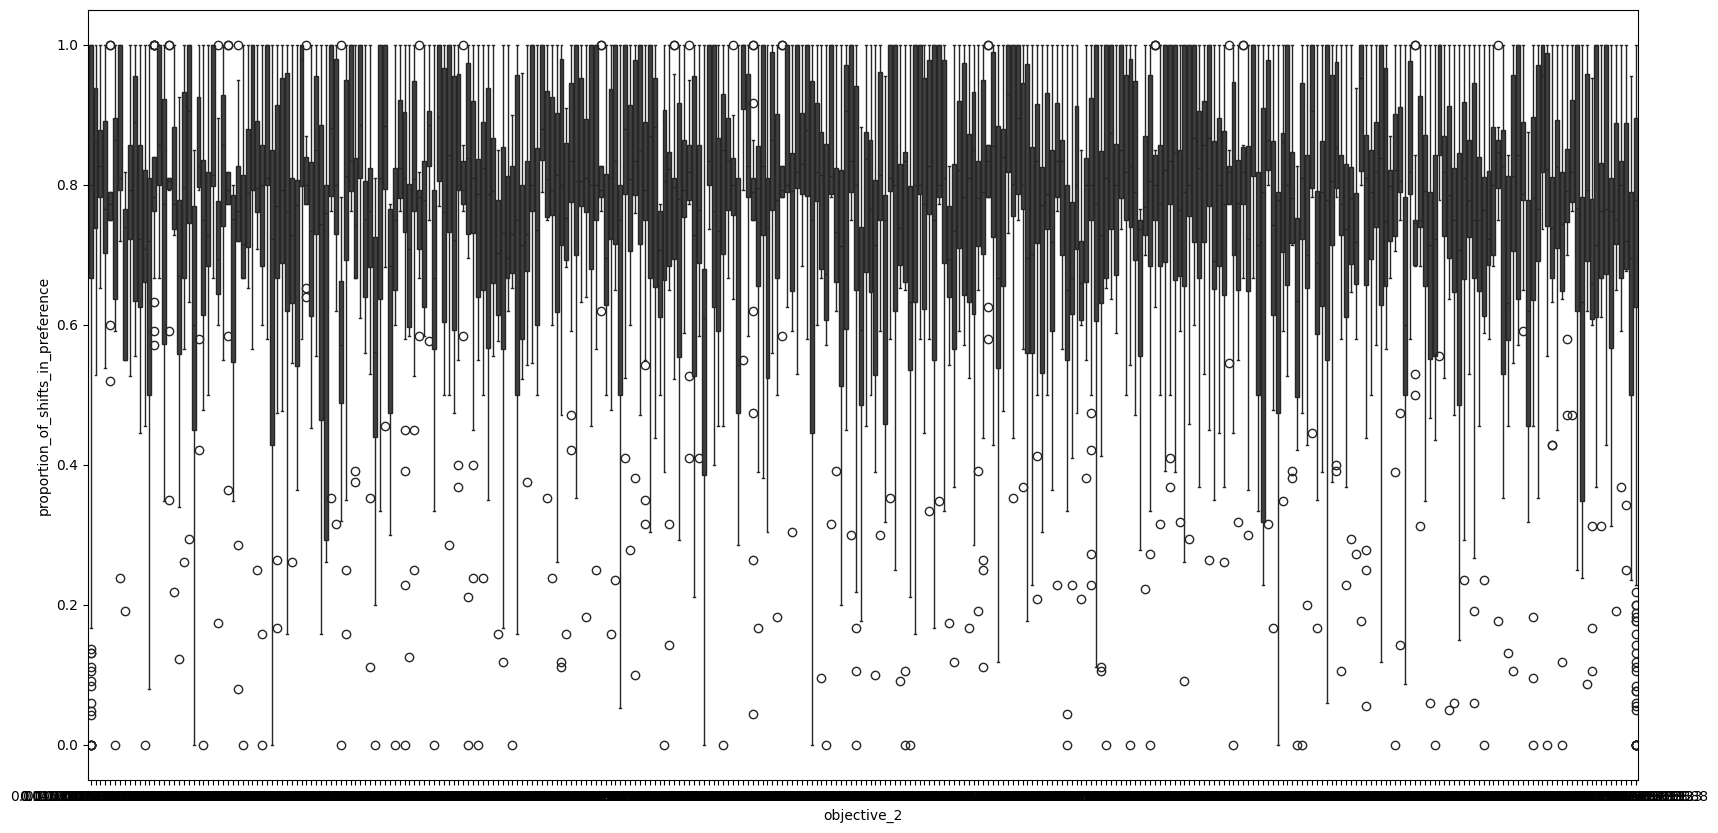

In [20]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(x="objective_2", y="proportion_of_shifts_in_preference",  data=df_all[df_all['non_dominated']==1], color=".25",ax=ax)
